## Pandas怎样实现groupby分组统计

类似SQL：  
select city,max(temperature) from city_weather group by city;

groupby：先对数据分组，然后在每个分组上应用聚合函数、转换函数

本次演示：  
一、分组使用聚合函数做数据统计  
二、遍历groupby的结果理解执行流程  
三、实例分组探索天气数据  

In [15]:
import pandas as pd
import numpy as np
# 加上这一句，能在jupyter notebook展示matplot图表
%matplotlib inline

In [16]:
df = pd.DataFrame({'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
                   'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
                   'C': np.random.randn(8),
                   'D': np.random.randn(8)})
df

,A,B,C,D
0,foo,one,-1.182427,-0.514513
1,bar,one,0.213008,-0.518546
2,foo,two,-1.523559,0.345913
3,bar,three,-0.392514,0.160755
4,foo,two,1.408309,0.813899
5,bar,two,1.674073,0.580359
6,foo,one,0.725334,-1.319398
7,foo,three,1.113611,-0.950354


### 一、分组使用聚合函数做数据统计

#### 1、单个列groupby，查询所有数据列的统计

In [17]:
df.groupby('A').sum()

,C,D
A,,
bar,1.494567,0.222568
foo,0.541267,-1.624452


我们看到：
1. groupby中的'A'变成了数据的索引列
2. 因为要统计sum，但B列不是数字，所以被自动忽略掉

#### 2、多个列groupby，查询所有数据列的统计

In [18]:
df.groupby(['A','B']).mean()

C         D
A   B                        
bar one    0.213008 -0.518546
    three -0.392514  0.160755
    two    1.674073  0.580359
foo one   -0.228546 -0.916955
    three  1.113611 -0.950354
    two   -0.057625  0.579906

我们看到：('A','B')成对变成了二级索引

In [19]:
df.groupby(['A','B'], as_index=False).mean()

,A,B,C,D
0,bar,one,0.213008,-0.518546
1,bar,three,-0.392514,0.160755
2,bar,two,1.674073,0.580359
3,foo,one,-0.228546,-0.916955
4,foo,three,1.113611,-0.950354
5,foo,two,-0.057625,0.579906


#### 3、同时查看多种数据统计

In [20]:
df.groupby('A').agg([np.sum, np.mean, np.std])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar  1.494567  0.498189  1.062399  0.222568  0.074189  0.554543
foo  0.541267  0.108253  1.361097 -1.624452 -0.324890  0.889245

我们看到：列变成了多级索引

#### 4、查看单列的结果数据统计

In [21]:
# 方法1：预过滤，性能更好
df.groupby('A')['C'].agg([np.sum, np.mean, np.std])

,sum,mean,std
A,,,
bar,1.494567,0.498189,1.062399
foo,0.541267,0.108253,1.361097


In [22]:
# 方法2
df.groupby('A').agg([np.sum, np.mean, np.std])['C']

,sum,mean,std
A,,,
bar,1.494567,0.498189,1.062399
foo,0.541267,0.108253,1.361097


#### 5、不同列使用不同的聚合函数

In [23]:
df.groupby('A').agg({"C":np.sum, "D":np.mean})

,C,D
A,,
bar,1.494567,0.074189
foo,0.541267,-0.324890


### 二、遍历groupby的结果理解执行流程

for循环可以直接遍历每个group

##### 1、遍历单个列聚合的分组

In [24]:
g = df.groupby('A')
g

In [25]:
for name,group in g:
    print(name)
    print(group)
    print()

bar
     A      B         C         D
1  bar    one  0.213008 -0.518546
3  bar  three -0.392514  0.160755
5  bar    two  1.674073  0.580359

foo
     A      B         C         D
0  foo    one -1.182427 -0.514513
2  foo    two -1.523559  0.345913
4  foo    two  1.408309  0.813899
6  foo    one  0.725334 -1.319398
7  foo  three  1.113611 -0.950354



***可以获取单个分组的数据***

In [26]:
g.get_group('bar')

,A,B,C,D
1,bar,one,0.213008,-0.518546
3,bar,three,-0.392514,0.160755
5,bar,two,1.674073,0.580359


##### 2、遍历多个列聚合的分组

In [27]:
g = df.groupby(['A', 'B'])

In [28]:
for name,group in g:
    print(name)
    print(group)
    print()

('bar', 'one')
     A    B         C         D
1  bar  one  0.213008 -0.518546

('bar', 'three')
     A      B         C         D
3  bar  three -0.392514  0.160755

('bar', 'two')
     A    B         C         D
5  bar  two  1.674073  0.580359

('foo', 'one')
     A    B         C         D
0  foo  one -1.182427 -0.514513
6  foo  one  0.725334 -1.319398

('foo', 'three')
     A      B         C         D
7  foo  three  1.113611 -0.950354

('foo', 'two')
     A    B         C         D
2  foo  two -1.523559  0.345913
4  foo  two  1.408309  0.813899



可以看到，name是一个2个元素的tuple，代表不同的列

In [29]:
g.get_group(('foo', 'one'))

,A,B,C,D
0,foo,one,-1.182427,-0.514513
6,foo,one,0.725334,-1.319398


***可以直接查询group后的某几列，生成Series或者子DataFrame***

In [30]:
g['C']

In [31]:
for name, group in g['C']:
    print(name)
    print(group)
    print(type(group))
    print()

('bar', 'one')
1    0.213008
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'three')
3   -0.392514
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('bar', 'two')
5    1.674073
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'one')
0   -1.182427
6    0.725334
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'three')
7    1.113611
Name: C, dtype: float64
<class 'pandas.core.series.Series'>

('foo', 'two')
2   -1.523559
4    1.408309
Name: C, dtype: float64
<class 'pandas.core.series.Series'>



其实所有的聚合统计，都是在dataframe和series上进行的；

### 三、实例分组探索天气数据

In [32]:
fpath = "./datas/beijing_tianqi/beijing_tianqi_2018.csv"
df = pd.read_csv(fpath)
# 替换掉温度的后缀℃
df.loc[:, "bWendu"] = df["bWendu"].str.replace("℃", "").astype('int32')
df.loc[:, "yWendu"] = df["yWendu"].str.replace("℃", "").astype('int32')
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1


In [33]:
# 新增一列为月份
df['month'] = df['ymd'].str[:7]
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2,2018-01
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1,2018-01
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1,2018-01
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1,2018-01
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1,2018-01


#### 1、查看每个月的最高温度

In [34]:
data = df.groupby('month')['bWendu'].max()
data

month
2018-01     7
2018-02    12
2018-03    27
2018-04    30
2018-05    35
2018-06    38
2018-07    37
2018-08    36
2018-09    31
2018-10    25
2018-11    18
2018-12    10
Name: bWendu, dtype: int32

In [35]:
type(data)

pandas.core.series.Series

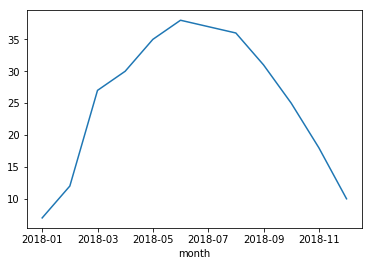

In [36]:
data.plot()

#### 2、查看每个月的最高温度、最低温度、平均空气质量指数

In [37]:
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month
0,2018-01-01,3,-6,晴~多云,东北风,1-2级,59,良,2,2018-01
1,2018-01-02,2,-5,阴~多云,东北风,1-2级,49,优,1,2018-01
2,2018-01-03,2,-5,多云,北风,1-2级,28,优,1,2018-01
3,2018-01-04,0,-8,阴,东北风,1-2级,28,优,1,2018-01
4,2018-01-05,3,-6,多云~晴,西北风,1-2级,50,优,1,2018-01


In [38]:
group_data = df.groupby('month').agg({"bWendu":np.max, "yWendu":np.min, "aqi":np.mean})
group_data

,bWendu,yWendu,aqi
month,,,
2018-01,7,-12,60.677419
2018-02,12,-10,78.857143
2018-03,27,-4,130.322581
2018-04,30,1,102.866667
2018-05,35,10,99.064516
2018-06,38,17,82.300000
2018-07,37,22,72.677419
2018-08,36,20,59.516129
2018-09,31,11,50.433333


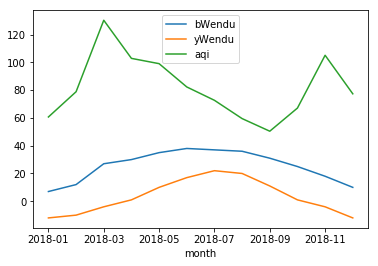

In [39]:
group_data.plot()